In [193]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install folium==0.5.0
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


<h5>I found the Second-level Administrative Divisions, Tunisia, 2015 - Digital Maps and Geospatial Data from University of California, Berkeley. The .json file has coordinates of all cities of Tunisia, i have converted to csv file for easy processing in my Notebook.<h5/><br> 
   <h5> Uploading the file <h45/>

In [194]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_0ca568d8dcb0447ab571f8ce182d09d0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='8BuTK3mYLmR_ONyXiPZyRadN02krsWQDVCcMyPPEXh66',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_0ca568d8dcb0447ab571f8ce182d09d0.get_object(Bucket='capstoneprojectuscoffeegiantstarb-donotdelete-pr-a94pqhwbrqgpji',Key='Second-level Administrative Divisions, Tunisia.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,type,features__type,features__id,features__geometry__type,Longitude,Latitude,features__geometry_name,features__properties__id_0,features__properties__iso,features__properties__name_0,...,Borough,features__properties__id_2,Neighborhood,features__properties__hasc_2,features__properties__ccn_2,features__properties__cca_2,features__properties__type_2,features__properties__engtype_2,features__properties__nl_name_2,features__properties__varname_2
0,FeatureCollection,Feature,zy373kj6079.1,MultiPolygon,10.193133,36.856560,geom,234,TUN,Tunisia,...,Ariana,1,Ariana Médina,TN.AN.AR,0,NaN,Delegation,Delegation,NaN,Ariana Medina
1,FeatureCollection,Feature,zy373kj6079.2,MultiPolygon,10.056228,36.842808,geom,234,TUN,Tunisia,...,Ariana,2,Ettadhamen,TN.AN.ET,0,NaN,Delegation,Delegation,NaN,NaN
2,FeatureCollection,Feature,zy373kj6079.3,MultiPolygon,10.218749,37.151249,geom,234,TUN,Tunisia,...,Ariana,3,Kalaat El Andalous,TN.AN.KA,0,NaN,Delegation,Delegation,NaN,NaN
3,FeatureCollection,Feature,zy373kj6079.4,MultiPolygon,10.131537,36.863815,geom,234,TUN,Tunisia,...,Ariana,4,Mnihla,TN.AN.MN,0,NaN,Delegation,Delegation,NaN,NaN
4,FeatureCollection,Feature,zy373kj6079.5,MultiPolygon,10.230476,36.955280,geom,234,TUN,Tunisia,...,Ariana,5,Raoued,TN.AN.RA,0,NaN,Delegation,Delegation,NaN,NaN


<h5>Scrape the "raw" table and keeping the required features.<h5/>

In [195]:
df = pd.DataFrame(df_data_1, columns = ["features__id", "Borough", "Neighborhood","Latitude","Longitude"])
df.head()

,features__id,Borough,Neighborhood,Latitude,Longitude
0,zy373kj6079.1,Ariana,Ariana Médina,36.856560,10.193133
1,zy373kj6079.2,Ariana,Ettadhamen,36.842808,10.056228
2,zy373kj6079.3,Ariana,Kalaat El Andalous,37.151249,10.218749
3,zy373kj6079.4,Ariana,Mnihla,36.863815,10.131537
4,zy373kj6079.5,Ariana,Raoued,36.955280,10.230476


<h5>Now let's clean the data and reduce it to the region of "Grand Tunis ":Grand Tunis is the name for the greatest metropolitan area in Tunisia, which assembles four of the following states: Tunis, Ariana, Manouba and Ben Arous. According to the latest population census in 2004, the area of Grand Tunis is the home of 2,247,800 people.[1] <h5/>

In [196]:
df_Tunis_clean= df [df['Borough'].str.contains("Tunis")|df['Borough'].str.contains("Ariana")|df['Borough'].str.contains("Manubah")|df['Borough'].str.contains("Ben Arous")].reset_index(drop=True)
df_Tunis_clean.head()

,features__id,Borough,Neighborhood,Latitude,Longitude
0,zy373kj6079.1,Ariana,Ariana Médina,36.856560,10.193133
1,zy373kj6079.2,Ariana,Ettadhamen,36.842808,10.056228
2,zy373kj6079.3,Ariana,Kalaat El Andalous,37.151249,10.218749
3,zy373kj6079.4,Ariana,Mnihla,36.863815,10.131537
4,zy373kj6079.5,Ariana,Raoued,36.955280,10.230476


<h5>Let's see how much of each borough is in our data set<h5/>
    

In [197]:
df_Tunis_clean ["Borough"].value_counts()

Tunis         22
Ben Arous     12
Manubah        8
Ariana         8
Name: Borough, dtype: int64

In [198]:
address = "ساعة شارع الحبيب بورقيبة "

geolocator = Nominatim(user_agent="Tunis")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tunis city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tunis city are 36.8002466, 10.1862002.


In [199]:
# create map of Tunis using latitude and longitude values
map_Tunis = folium.Map(location=[latitude, longitude], zoom_start=12)
map_Tunis

In [200]:
for Latitude, Longitude, Borough, Neighborhood in zip(
        df_Tunis_clean['Latitude'], 
        df_Tunis_clean['Longitude'], 
        df_Tunis_clean['Borough'], 
        df_Tunis_clean['Neighborhood']):
    label = '{}, {}'.format(Neighborhood,Borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
       ).add_to(map_Tunis)  

map_Tunis

<h5>Define Foursquare Credentials and Version<h5/>

In [201]:
CLIENT_ID = 'IOPMVZIUATAYXB0XJLL3BBG5ZCZABZG00QG3YEU25QTMQ1RA'
CLIENT_SECRET = 'KPZ4XE1JXUY4EDT2GIH5KIO5FRETATLJR15PB0LE5BJ5L5FB'
VERSION = '20180604'

<h5>Explore the first neighborhood in our data frame "df_Tunis_clean"<h5/>

In [202]:
neighborhood_name = df_Tunis_clean.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'Ariana Médina'.


In [203]:
neighborhood_latitude = df_Tunis_clean.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_Tunis_clean.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ariana Médina are 36.85655975, 10.19313335.


<h5>Now, let's get the top 100 venues that are in Bab Bhar within a radius of 500 meters.<h5/>

In [204]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

<h5>Function that extracts the category of the venue<h5/>

In [205]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h5>Now we are ready to clean the json and structure it into a pandas dataframe<h5/>

In [206]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,صحن تونسي عند لطفي,African Restaurant,36.859091,10.188879
1,Woodstock,Fast Food Restaurant,36.855739,10.187889
2,El Borj,Fast Food Restaurant,36.855375,10.195601
3,Baguette & Baguette Ariana,Burger Joint,36.857064,10.188687
4,La Friandise,Dessert Shop,36.858211,10.191946
5,Cafés BONDIN,Coffee Shop,36.858942,10.191740
6,Yasmine Coffee,Café,36.856276,10.194643
7,Kafteji Ellas,Fast Food Restaurant,36.858585,10.189685
8,cafe Belar,Café,36.857106,10.188519
9,Chill-out café,Café,36.857249,10.194428


<h5>Explore all the neighborhoods in this part of Tunis City<br>

We are working on the data frame df_Tunis_clean ,recall that, this region contains the boroughs of Bab Bhar,Bouhaira et El Menzah .


First, let's create a function to repeat the same process to all the neighborhoods in df_Tunis_clean.

In [207]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h5>Now write the code to run the above function on each neighborhood and create a new dataframe called Tunis_city_venues<h5/>

In [208]:
Tunis_city_venues = getNearbyVenues(names=df_Tunis_clean['Neighborhood'],
                                   latitudes=df_Tunis_clean['Latitude'],
                                   longitudes=df_Tunis_clean['Longitude']
                                  )

In [209]:
Tunis_city_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ariana Médina,36.85656,10.193133,صحن تونسي عند لطفي,36.859091,10.188879,African Restaurant
1,Ariana Médina,36.85656,10.193133,Woodstock,36.855739,10.187889,Fast Food Restaurant
2,Ariana Médina,36.85656,10.193133,El Borj,36.855375,10.195601,Fast Food Restaurant
3,Ariana Médina,36.85656,10.193133,Baguette & Baguette Ariana,36.857064,10.188687,Burger Joint
4,Ariana Médina,36.85656,10.193133,La Friandise,36.858211,10.191946,Dessert Shop


<h5>Let's check how many venues were returned for each neighborhood.<h5/>

In [210]:
Tunis_city_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ariana Médina,25,25,25,25,25,25
Bab Bhar,21,21,21,21,21,21
Bab Souika,15,15,15,15,15,15
Bardo,2,2,2,2,2,2
Bouhaira,13,13,13,13,13,13
Carthage,7,7,7,7,7,7
Cité El Khadra,3,3,3,3,3,3
El Menzah,3,3,3,3,3,3
El Mourouj,4,4,4,4,4,4


<h5>Let's find out how many unique categories can be curated from all the returned venues<h5/>

In [211]:
print('There are {} uniques categories.'.format(len(Tunis_city_venues['Venue Category'].unique())))

There are 58 uniques categories.


<h5>Analyze Each Neighborhood<h5/>

In [212]:
# one hot encoding
Tunis_city_onehot = pd.get_dummies(Tunis_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Tunis_city_onehot['Neighborhood'] = Tunis_city_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Tunis_city_onehot.columns[-1]] + list(Tunis_city_onehot.columns[:-1])
Tunis_city_onehot = Tunis_city_onehot[fixed_columns]

Tunis_city_onehot.head()

,Neighborhood,African Restaurant,Arcade,Art Gallery,Auto Workshop,Bakery,Bar,Beach,Beer Garden,Bookstore,...,Sandwich Place,Seafood Restaurant,Smoke Shop,Snack Place,Soccer Stadium,Supermarket,Tea Room,Theater,Train Station,Video Game Store
0,Ariana Médina,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ariana Médina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ariana Médina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ariana Médina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ariana Médina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h5>Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category<h5/>

In [213]:
Tunis_city_grouped = Tunis_city_onehot.groupby('Neighborhood').mean().reset_index()
Tunis_city_grouped.head()

,Neighborhood,African Restaurant,Arcade,Art Gallery,Auto Workshop,Bakery,Bar,Beach,Beer Garden,Bookstore,...,Sandwich Place,Seafood Restaurant,Smoke Shop,Snack Place,Soccer Stadium,Supermarket,Tea Room,Theater,Train Station,Video Game Store
0,Ariana Médina,0.040000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.04,0.000000,0.0,0.000000,0.0,0.0,0.04,0.000000,0.0,0.0
1,Bab Bhar,0.047619,0.0,0.047619,0.047619,0.000000,0.047619,0.0,0.0,0.000000,...,0.00,0.047619,0.0,0.000000,0.0,0.0,0.00,0.095238,0.0,0.0
2,Bab Souika,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.0,0.0,0.066667,...,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0
3,Bardo,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0
4,Bouhaira,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.00,0.000000,0.0,0.076923,0.0,0.0,0.00,0.000000,0.0,0.0


<h5>Check the 10 most common venues in each neighborhood.<h5/>

In [214]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Tunis_city_grouped['Neighborhood']

for ind in np.arange(Tunis_city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tunis_city_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ariana Médina,Café,Fast Food Restaurant,Coffee Shop,Food & Drink Shop,Burger Joint,Farmers Market,Dessert Shop,Metro Station,Pharmacy,African Restaurant
1,Bab Bhar,Electronics Store,Theater,Movie Theater,Bus Station,Dessert Shop,Garden,Gastropub,Mac & Cheese Joint,Café,Cafeteria
2,Bab Souika,Plaza,Café,Metro Station,Market,Restaurant,Food Truck,Bakery,Bookstore,Diner,Dessert Shop
3,Bardo,Dessert Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Department Store
4,Bouhaira,Café,Diner,Coffee Shop,Pizza Place,Cupcake Shop,Restaurant,Fast Food Restaurant,Snack Place,General Entertainment,Falafel Restaurant


<h5>Cluster neighborhoods<br>

Let's run k-means to cluster the neighborhood into 5 clusters.<h5/>

In [215]:
# set number of clusters
kclusters = 5

Tunis_city_grouped_clustering = Tunis_city_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tunis_city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 2, 2, 2, 1, 2], dtype=int32)

In [216]:
neighborhoods_venues_sorted.insert(0,'Cluster label', kmeans.labels_)

Tunis_city_merged = df_Tunis_clean

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Tunis_city_merged = Tunis_city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Tunis_city_merged.head() # check the last columns!

,features__id,Borough,Neighborhood,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,zy373kj6079.1,Ariana,Ariana Médina,36.856560,10.193133,1.0,Café,Fast Food Restaurant,Coffee Shop,Food & Drink Shop,Burger Joint,Farmers Market,Dessert Shop,Metro Station,Pharmacy,African Restaurant
1,zy373kj6079.2,Ariana,Ettadhamen,36.842808,10.056228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zy373kj6079.3,Ariana,Kalaat El Andalous,37.151249,10.218749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,zy373kj6079.4,Ariana,Mnihla,36.863815,10.131537,4.0,Coffee Shop,Bakery,Pizza Place,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner
4,zy373kj6079.5,Ariana,Raoued,36.955280,10.230476,4.0,Coffee Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop


In [217]:
Tunis_city_merged.dropna(subset=["Cluster label"],axis=0,inplace=True)
Tunis_city_merged.reset_index(drop=True,inplace=True)
Tunis_city_merged.head(5)

,features__id,Borough,Neighborhood,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,zy373kj6079.1,Ariana,Ariana Médina,36.856560,10.193133,1.0,Café,Fast Food Restaurant,Coffee Shop,Food & Drink Shop,Burger Joint,Farmers Market,Dessert Shop,Metro Station,Pharmacy,African Restaurant
1,zy373kj6079.4,Ariana,Mnihla,36.863815,10.131537,4.0,Coffee Shop,Bakery,Pizza Place,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner
2,zy373kj6079.5,Ariana,Raoued,36.955280,10.230476,4.0,Coffee Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
3,zy373kj6079.8,Ariana,Soukra,36.870617,10.279025,2.0,Furniture / Home Store,Health & Beauty Service,Outdoor Supply Store,Food Truck,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
4,zy373kj6079.23,Ben Arous,Hammam Chott,36.717083,10.385272,3.0,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


In [218]:
Tunis_city_merged["Cluster label"].value_counts()

2.0    16
1.0     7
4.0     4
0.0     1
3.0     1
Name: Cluster label, dtype: int64

In [219]:
Tunis_city_merged["Cluster label"]=Tunis_city_merged["Cluster label"].astype(int)
Tunis_city_merged.head(5)

,features__id,Borough,Neighborhood,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,zy373kj6079.1,Ariana,Ariana Médina,36.856560,10.193133,1,Café,Fast Food Restaurant,Coffee Shop,Food & Drink Shop,Burger Joint,Farmers Market,Dessert Shop,Metro Station,Pharmacy,African Restaurant
1,zy373kj6079.4,Ariana,Mnihla,36.863815,10.131537,4,Coffee Shop,Bakery,Pizza Place,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner
2,zy373kj6079.5,Ariana,Raoued,36.955280,10.230476,4,Coffee Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
3,zy373kj6079.8,Ariana,Soukra,36.870617,10.279025,2,Furniture / Home Store,Health & Beauty Service,Outdoor Supply Store,Food Truck,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
4,zy373kj6079.23,Ben Arous,Hammam Chott,36.717083,10.385272,3,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


In [220]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        Tunis_city_merged['Latitude'], 
        Tunis_city_merged['Longitude'], 
        Tunis_city_merged['Neighborhood'], 
        Tunis_city_merged['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h5>Examine Clusters
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.<h5/>

<h5>Cluster 1<h5/>

In [221]:
 Tunis_city_merged.loc[ Tunis_city_merged['Cluster label'] == 0,  Tunis_city_merged.columns[[1] + list(range(5,  Tunis_city_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Ben Arous,0,Auto Workshop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop


In [222]:
 Tunis_city_merged.loc[ Tunis_city_merged['Cluster label'] == 1,  Tunis_city_merged.columns[[1] + list(range(5,  Tunis_city_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ariana,1,Café,Fast Food Restaurant,Coffee Shop,Food & Drink Shop,Burger Joint,Farmers Market,Dessert Shop,Metro Station,Pharmacy,African Restaurant
7,Ben Arous,1,Cafeteria,Café,Fast Food Restaurant,Cupcake Shop,Food & Drink Shop,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
8,Ben Arous,1,Café,Farmers Market,Video Game Store,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
9,Ben Arous,1,Café,Farmers Market,Video Game Store,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
10,Tunis,1,Cafeteria,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
23,Tunis,1,Café,Video Game Store,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
26,Tunis,1,Cafeteria,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


In [223]:
Tunis_city_merged.loc[ Tunis_city_merged['Cluster label'] == 2,  Tunis_city_merged.columns[[1] + list(range(5,  Tunis_city_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Ariana,2,Furniture / Home Store,Health & Beauty Service,Outdoor Supply Store,Food Truck,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
5,Ben Arous,2,Plaza,Beach,Arcade,Supermarket,Dessert Shop,Comedy Club,Convenience Store,Cupcake Shop,Department Store,Video Game Store
11,Tunis,2,Electronics Store,Theater,Movie Theater,Bus Station,Dessert Shop,Garden,Gastropub,Mac & Cheese Joint,Café,Cafeteria
12,Tunis,2,Plaza,Café,Metro Station,Market,Restaurant,Food Truck,Bakery,Bookstore,Diner,Dessert Shop
13,Tunis,2,Dessert Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Department Store
14,Tunis,2,Café,Diner,Coffee Shop,Pizza Place,Cupcake Shop,Restaurant,Fast Food Restaurant,Snack Place,General Entertainment,Falafel Restaurant
15,Tunis,2,Grocery Store,Bridal Shop,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
16,Tunis,2,Electronics Store,Theater,Movie Theater,Bus Station,Dessert Shop,Garden,Gastropub,Mac & Cheese Joint,Café,Cafeteria
17,Tunis,2,Park,Beach,Gastropub,Historic Site,Comedy Club,Restaurant,Fast Food Restaurant,Bar,Beer Garden,Farmers Market
18,Tunis,2,Soccer Stadium,Historic Site,Mobile Phone Shop,Video Game Store,Café,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop


In [224]:
Tunis_city_merged.loc[ Tunis_city_merged['Cluster label'] == 3,  Tunis_city_merged.columns[[1] + list(range(5,  Tunis_city_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Ben Arous,3,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


In [225]:
Tunis_city_merged.loc[ Tunis_city_merged['Cluster label'] == 4,  Tunis_city_merged.columns[[1] + list(range(5,  Tunis_city_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ariana,4,Coffee Shop,Bakery,Pizza Place,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner
2,Ariana,4,Coffee Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop
21,Tunis,4,Convenience Store,Coffee Shop,Video Game Store,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner
27,Tunis,4,Coffee Shop,Bakery,Pizza Place,Video Game Store,Café,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner


In [226]:

body = client_0ca568d8dcb0447ab571f8ce182d09d0.get_object(Bucket='capstoneprojectuscoffeegiantstarb-donotdelete-pr-a94pqhwbrqgpji',Key='Social Prameters.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()


,Borough,Neighborhood,Neighborhoods Score,C_living_score,Rank
0,Tunis,Carthage,583.49,0.77,3
1,Tunis,Médina,353.92,0.47,47
2,Tunis,Bab Bhar,323.15,0.43,48
3,Tunis,Bab Souika,390.03,0.52,46
4,Tunis,Omrane,483.66,0.64,31


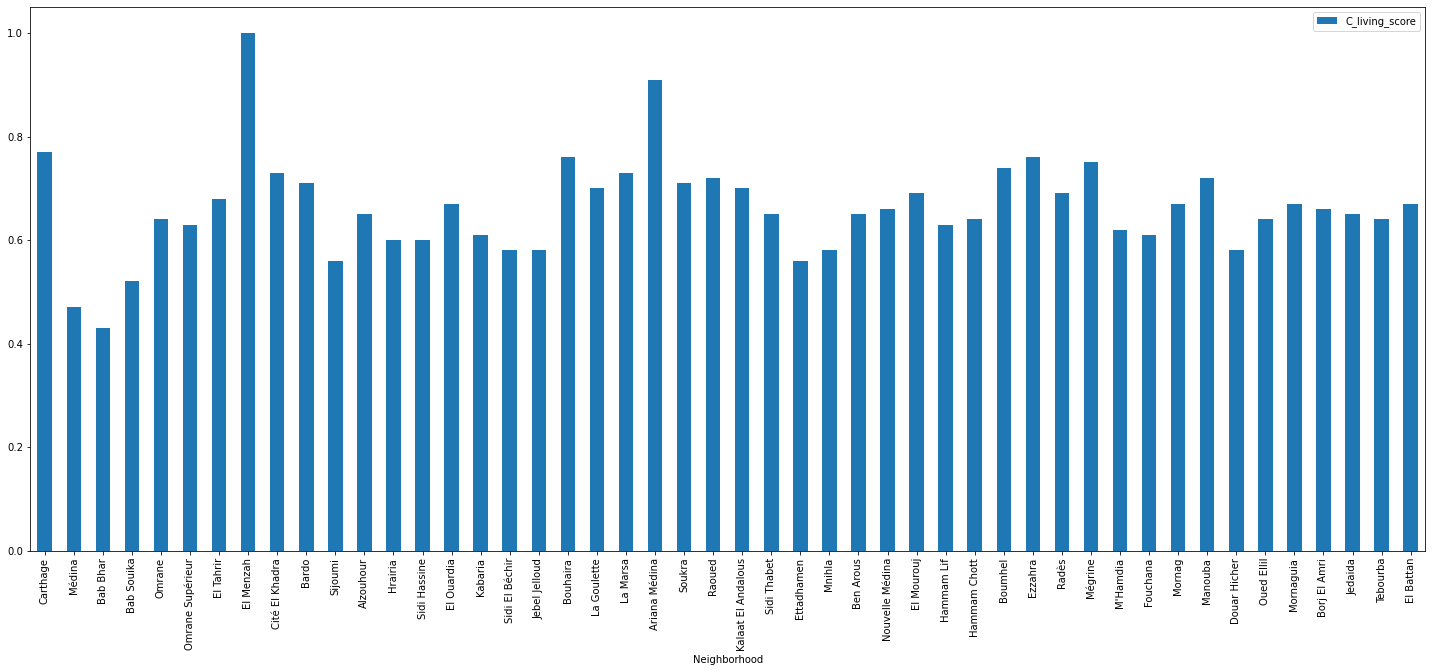

In [227]:
ax=df_data_2.set_index('Neighborhood')['C_living_score'].plot.bar(figsize=(25,10))
ax.legend()

<h5>Let's merge those new variables with related cluster informations in our main Tunis_city_merged table.<h5/>

In [228]:
Grand_Tunis_city_df = pd.merge( df_data_2,Tunis_city_merged)
Grand_Tunis_city_df.head()

,Borough,Neighborhood,Neighborhoods Score,C_living_score,Rank,features__id,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tunis,Carthage,583.49,0.77,3,zy373kj6079.244,36.837360,10.324494,2,Park,Beach,Gastropub,Historic Site,Comedy Club,Restaurant,Fast Food Restaurant,Bar,Beer Garden,Farmers Market
1,Tunis,Médina,353.92,0.47,47,zy373kj6079.255,36.803280,10.159868,1,Cafeteria,Café,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
2,Tunis,Bab Bhar,323.15,0.43,48,zy373kj6079.240,36.794762,10.184002,2,Electronics Store,Theater,Movie Theater,Bus Station,Dessert Shop,Garden,Gastropub,Mac & Cheese Joint,Café,Cafeteria
3,Tunis,Bab Souika,390.03,0.52,46,zy373kj6079.241,36.810127,10.169404,2,Plaza,Café,Metro Station,Market,Restaurant,Food Truck,Bakery,Bookstore,Diner,Dessert Shop
4,Tunis,Omrane,483.66,0.64,31,zy373kj6079.257,36.826145,10.169377,2,Soccer Stadium,Historic Site,Mobile Phone Shop,Video Game Store,Café,Farmers Market,Falafel Restaurant,Electronics Store,Diner,Dessert Shop


In [229]:
len(Grand_Tunis_city_df)

22

<h5>let's select the required columns for our assessement which are Borough, Neighborhood,Claster label,1st and 2nd Most common Venue,Cost Living Score and Rnking<h5/>

In [230]:
print(Grand_Tunis_city_df.columns.values)

['Borough' 'Neighborhood' 'Neighborhoods Score' 'C_living_score' ' Rank '
 'features__id' 'Latitude' 'Longitude' 'Cluster label'
 '1st Most Common Venue' '2nd Most Common Venue' '3rd Most Common Venue'
 '4th Most Common Venue' '5th Most Common Venue' '6th Most Common Venue'
 '7th Most Common Venue' '8th Most Common Venue' '9th Most Common Venue'
 '10th Most Common Venue']


In [231]:
Grand_Tunis_city_df1=Grand_Tunis_city_df[['Neighborhood','Cluster label','1st Most Common Venue','2nd Most Common Venue','C_living_score']]
Grand_Tunis_city_df1.head(22)

,Neighborhood,Cluster label,1st Most Common Venue,2nd Most Common Venue,C_living_score
0,Carthage,2,Park,Beach,0.77
1,Médina,1,Cafeteria,Café,0.47
2,Bab Bhar,2,Electronics Store,Theater,0.43
3,Bab Souika,2,Plaza,Café,0.52
4,Omrane,2,Soccer Stadium,Historic Site,0.64
5,Omrane Supérieur,4,Coffee Shop,Bakery,0.63
6,El Tahrir,4,Convenience Store,Coffee Shop,0.68
7,El Menzah,2,Soccer Stadium,Historic Site,1.00
8,Cité El Khadra,2,Soccer Stadium,Historic Site,0.73
9,Bardo,2,Dessert Shop,Video Game Store,0.71


<h5>Now ,the above table will be our data base for the selection of the 5 most suitable locations for Sturbuks to set up their first stores in Grand Tunis.<h5/>
 <h5>Our startegy is to find locations that doesn’t already have a bunch of locally owned coffee shops, and has higher cost living index (please refer to the report for more details)<h5/>
<h5>So let's define a new data frame which select locations based on two parameters as follows:<h5/>
   <h5>1- Not coffee shops as 1st common venue<h5/>
   <h5>2- Cost living index higher than 0.7<h5> 

In [232]:
Grand_Tunis_city_Starbucks = Grand_Tunis_city_df1[Grand_Tunis_city_df['C_living_score']>=0.70 ]
len(Grand_Tunis_city_Starbucks)


10

In [233]:
Grand_Tunis_city_Starbucks = Grand_Tunis_city_df1[Grand_Tunis_city_df['C_living_score']>=0.70 ]
Grand_Tunis_city_Starbucks.head(10)

,Neighborhood,Cluster label,1st Most Common Venue,2nd Most Common Venue,C_living_score
0,Carthage,2,Park,Beach,0.77
7,El Menzah,2,Soccer Stadium,Historic Site,1.00
8,Cité El Khadra,2,Soccer Stadium,Historic Site,0.73
9,Bardo,2,Dessert Shop,Video Game Store,0.71
15,Bouhaira,2,Café,Diner,0.76
16,La Goulette,2,Park,Beach,0.70
17,La Marsa,2,Furniture / Home Store,Health & Beauty Service,0.73
18,Ariana Médina,1,Café,Fast Food Restaurant,0.91
19,Soukra,2,Furniture / Home Store,Health & Beauty Service,0.71
20,Raoued,4,Coffee Shop,Video Game Store,0.72


In [234]:
Grand_Tunis_city_Starbucks = Grand_Tunis_city_Starbucks [Grand_Tunis_city_Starbucks['1st Most Common Venue'].str.contains("Caf*")== False]
Grand_Tunis_city_Starbucks1 = Grand_Tunis_city_Starbucks [Grand_Tunis_city_Starbucks['1st Most Common Venue'].str.contains("Cof*")== False]
Grand_Tunis_city_Starbucks1.head(10)

,Neighborhood,Cluster label,1st Most Common Venue,2nd Most Common Venue,C_living_score
0,Carthage,2,Park,Beach,0.77
7,El Menzah,2,Soccer Stadium,Historic Site,1.00
8,Cité El Khadra,2,Soccer Stadium,Historic Site,0.73
9,Bardo,2,Dessert Shop,Video Game Store,0.71
16,La Goulette,2,Park,Beach,0.70
17,La Marsa,2,Furniture / Home Store,Health & Beauty Service,0.73
19,Soukra,2,Furniture / Home Store,Health & Beauty Service,0.71


<h5>So above are the most convinient neighborhoods in Grand Tunis where Starbucks or the retails business partner could open the first batches of stores . Choosing among the above list will garantee for the store to be competitively positioned in high-demand areas.<h5/>